In [3]:
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import itertools
from tqdm.notebook import tqdm

In [4]:
# Load results from wandb
api = wandb.Api()
user_name = "dhdhagar"
project_name = "ttt-arc"
runs = api.runs(f"{user_name}/{project_name}", filters={
    "state": "finished",
})

In [5]:
# Load "small" tasks
with open('../data/arc/arc-small_tasks.json', 'r') as fh:
    small_tasks = json.load(fh)
    expected_n_results = len(small_tasks)

In [6]:
# Load task difficulty
with open('../data/arc/arc-all_tasks.json', 'r') as fh:
    all_tasks = json.load(fh)

In [7]:
task_difficulty = {k: v['level'] for k,v in all_tasks.items()}
task_train_examples = {k: v['num_train_examples'] for k,v in all_tasks.items()}

In [8]:
# Get runs by tags
tags = None
all_tags = [
   ["sft"], ["sft", "train_temp=sched"], ["pro", "oracle"], ["pro", "online"], ["sft", "pro", "oracle"],
   ["grpo", "oracle"], ["grpo", "online"], ["grpo", "beta0", "oracle"], ["grpo", "ns-best", "oracle"], ["grpo", "ns-mix", "oracle"], ["no_train"],
    ["grpo", "oracle", "full"], ["sft", "train_temp=sched", "full"]
]

In [9]:
# Load results
results = []
seen = set()
for run in tqdm(runs):
    # if all(tag in run.tags for tag in tags):
    if (tags is None and any(set(run.tags) == set(t) for t in all_tags)) or (tags is not None and set(run.tags) == set(tags)):
        unique_id = f"{run.config['target']}_{run.tags}"
        if unique_id not in seen:
            results.append({
                "target": run.config["target"],
                "tags": ",".join(sorted(set(run.tags))),
                **run.summary
            })
            seen.add(unique_id)

# Convert results into dataframe
all_res_df = pd.DataFrame(results)

if tags is not None:
   assert len(all_res_df) == expected_n_results, f"Expected {expected_n_results} results, got {len(all_res_df)} results. Missing targets: {set(small_tasks.keys()) - set(all_res_df.target.tolist())}"

# Convert any boolean datatypes to int
for col in all_res_df.columns:
    if all_res_df[col].dtype == bool:
        all_res_df[col] = all_res_df[col].astype(int)

  0%|          | 0/1574 [00:00<?, ?it/s]

In [10]:
# Columns to show
numerical_cols = ["_runtime", "test/solved_majority", "test/solved_majority_pass2", "test/solved_oracle",
                  "test/best_score", "test/score_majority", "test/score_majority_pass2", "validation/majority_reward",
                  "validation/majority_count", "train/reward_minus_replacement_mean",
                  "train/reward_minus_replacement_max"]
cols_to_show = ["tags", "target"] + numerical_cols

res_df = all_res_df[cols_to_show]

In [11]:
# Change occurrence of tag "oracle" to "supervised" in tags column
res_df.loc[:, "tags"] = res_df["tags"].apply(lambda x: x.replace("oracle", "supervised"))

In [12]:
# # Show results for one configuration
# res_df.describe()

# Show all results
_res_df = res_df[['tags'] + numerical_cols].groupby("tags").mean()
_res_df = _res_df.sort_values(["test/solved_majority_pass2", "test/solved_majority", "test/solved_oracle", "test/best_score"], ascending=True)
# Add a count column as the 1st column
_res_df.insert(0, "count", res_df[['tags', 'target']].groupby("tags").count())
_res_df

,count,_runtime,test/solved_majority,test/solved_majority_pass2,test/solved_oracle,test/best_score,test/score_majority,test/score_majority_pass2,validation/majority_reward,validation/majority_count,train/reward_minus_replacement_mean,train/reward_minus_replacement_max
tags,,,,,,,,,,,,
"full,grpo,supervised",237,2051.629581,0.109705,0.126582,0.156118,0.520282,0.467842,0.494181,0.644028,5.097046,0.711952,0.791028
"full,sft,train_temp=sched",193,1531.188031,0.093264,0.129534,0.181347,0.525143,0.461756,0.491551,0.545484,4.782383,0.621337,0.621337
"online,pro",54,282.565988,0.296296,0.425926,0.481481,0.858366,NaN,NaN,0.767570,17.314815,0.653914,0.755778
"grpo,online",54,430.278034,0.314815,0.425926,0.462963,0.870253,NaN,NaN,0.789387,16.759259,0.653499,0.746892
"supervised,pro",54,242.486204,0.351852,0.481481,0.537037,0.899679,NaN,NaN,0.823586,18.740741,0.728166,0.831245
"grpo,ns-mix,supervised",54,579.714666,0.370370,0.481481,0.518519,0.856647,0.781823,0.824749,0.719439,16.425926,0.740047,0.942185
"grpo,ns-best,supervised",54,375.636667,0.388889,0.500000,0.592593,0.822821,0.710319,0.759037,0.672068,17.166667,0.769125,0.965100
sft,54,131.012640,0.351852,0.518519,0.555556,0.878520,NaN,NaN,0.788739,18.092593,0.731850,0.731850
"supervised,pro,sft",54,219.020248,0.370370,0.518519,0.574074,0.911957,NaN,NaN,0.803357,17.777778,0.734850,0.848389


In [14]:
# Export this dataframe as a markdown table
_md_table = res_df[~res_df['tags'].str.contains("full")][['tags'] + numerical_cols].groupby("tags").mean()
_md_table = _md_table.sort_values("test/solved_majority_pass2", ascending=True)
print(_md_table.to_markdown(index=True))

| tags                 |   _runtime |   test/solved_majority |   test/solved_majority_pass2 |   test/solved_oracle |   test/best_score |   validation/majority_reward |   validation/majority_count |   train/reward_minus_replacement_mean |   train/reward_minus_replacement_max |
|:---------------------|-----------:|-----------------------:|-----------------------------:|---------------------:|------------------:|-----------------------------:|----------------------------:|--------------------------------------:|-------------------------------------:|
| grpo,online          |    430.278 |               0.314815 |                     0.425926 |             0.462963 |          0.870253 |                     0.789387 |                     16.7593 |                              0.653499 |                             0.746892 |
| online,pro           |    282.566 |               0.296296 |                     0.425926 |             0.481481 |          0.858366 |                     0.76757  |  

In [13]:
# View the resuls for "full,grpo,supervised" by task difficulty
res_df_full = res_df[res_df['tags'].str.contains("full,grpo,supervised")]
res_df_full = res_df_full.sort_values("test/solved_majority_pass2", ascending=True)
res_df_full["task_difficulty"] = res_df_full["target"].apply(lambda x: task_difficulty[x])
res_df_full["task_train_examples"] = res_df_full["target"].apply(lambda x: str(task_train_examples[x]))
res_df_full = res_df_full.sort_values("task_difficulty", ascending=True)
# Show results
res_df_full[["task_difficulty"] + numerical_cols].groupby("task_difficulty").mean()
# res_df_full[["task_train_examples"] + numerical_cols].groupby("task_train_examples").mean()

,_runtime,test/solved_majority,test/solved_majority_pass2,test/solved_oracle,test/best_score,test/score_majority,test/score_majority_pass2,validation/majority_reward,validation/majority_count,train/reward_minus_replacement_mean,train/reward_minus_replacement_max
task_difficulty,,,,,,,,,,,
easy,1721.716170,0.171429,0.200000,0.219048,0.554099,0.502787,0.531326,0.644221,3.619048,0.705332,0.795230
expert,3422.251446,0.000000,0.000000,0.000000,0.385037,0.360694,0.374980,0.391458,3.300000,0.656927,0.728329
hard,1994.841750,0.025641,0.051282,0.076923,0.607441,0.548424,0.567396,0.716730,11.333333,0.715334,0.779198
medium,2330.538195,0.084337,0.084337,0.132530,0.452841,0.398680,0.427149,0.640053,4.253012,0.725368,0.798824


In [34]:
res_df_not_full = res_df[~res_df['tags'].str.contains("full")]
res_df_full = res_df[res_df['tags'].str.contains("full")]

In [40]:
res_df_full[['tags'] + numerical_cols].groupby("tags").mean()

# Create new column aggregating test and validation solved status with an or condition
res_df_full.insert(0, "solved_test_valid", (res_df_full["test/solved_majority_pass2"] == 1) | (res_df_full["validation/majority_reward"] == 1))

ValueError: cannot insert solved_test_valid, already exists

In [44]:
res_df_full[res_df_full["solved_test_valid"] == 0]

,tags,target,_runtime,test/solved_majority,test/solved_majority_pass2,test/solved_oracle,test/best_score,test/score_majority,test/score_majority_pass2,validation/majority_reward,validation/majority_count,train/reward_minus_replacement_mean,train/reward_minus_replacement_max,solved_test_valid
540,"full,sft,train_temp=sched",782b5218,1438.799311,False,False,False,0.860000,0.460000,0.460000,0.290000,3,1.000000,1.000000,False
541,"full,sft,train_temp=sched",ff72ca3e,1140.944812,NaN,NaN,NaN,NaN,NaN,NaN,0.641667,4,1.000000,1.000000,False
543,"full,sft,train_temp=sched",93b4f4b3,640.346043,False,False,False,0.858824,0.858824,0.858824,0.733333,1,1.000000,1.000000,False
545,"full,sft,train_temp=sched",85fa5666,1470.628006,NaN,NaN,NaN,NaN,NaN,NaN,0.913580,8,1.000000,1.000000,False
548,"full,sft,train_temp=sched",2697da3f,2019.094045,NaN,NaN,NaN,NaN,NaN,NaN,0.342222,4,0.484444,0.484444,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
918,"full,grpo,oracle",0f63c0b9,3433.182864,False,False,False,0.000000,0.000000,0.000000,0.000000,1,0.007407,0.066667,False
919,"full,grpo,oracle",c64f1187,2634.359032,False,False,False,0.000000,0.000000,0.000000,0.647727,1,1.000000,1.000000,False
920,"full,grpo,oracle",d931c21c,2245.675214,False,False,False,0.000000,0.000000,0.000000,0.531250,2,0.491228,0.710526,False
921,"full,grpo,oracle",96a8c0cd,2721.021496,False,False,False,0.000000,0.000000,0.000000,0.821970,1,0.146465,0.738636,False


In [42]:
res_df_full[["tags", "solved_test_valid"]].groupby("tags").mean()

,solved_test_valid
tags,
"full,grpo,oracle",0.228311
"full,sft,train_temp=sched",0.206061


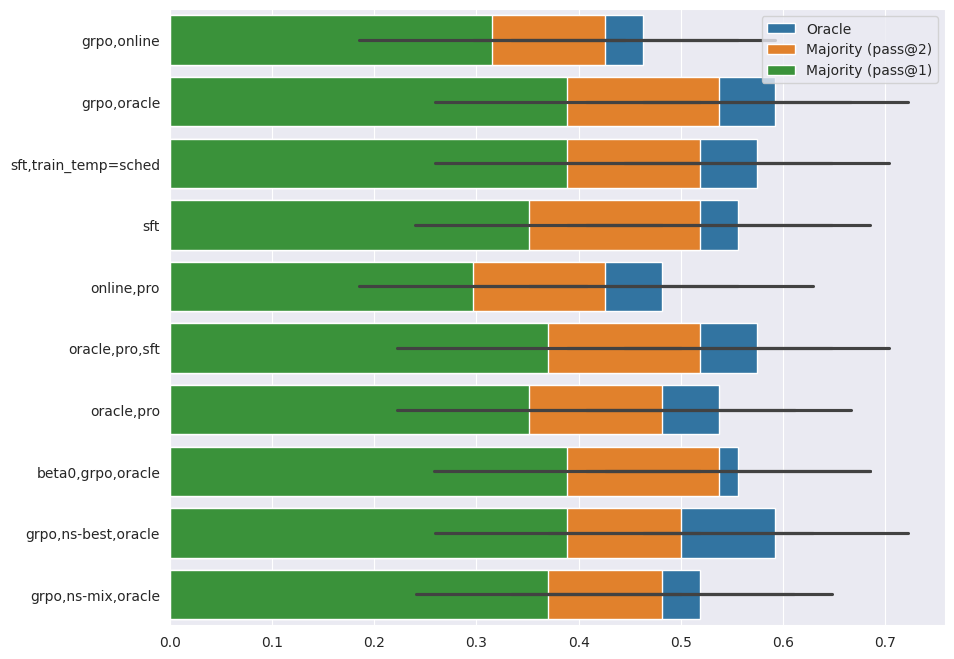

In [16]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(data=res_df, x="test/solved_oracle", y="tags", ax=ax, label="Oracle")
sns.barplot(data=res_df, x="test/solved_majority_pass2", y="tags", ax=ax, label="Majority (pass@2)")
sns.barplot(data=res_df, x="test/solved_majority", y="tags", ax=ax, label="Majority (pass@1)")
# Add legend
ax.legend()
# Hide x/y labels
ax.set_xlabel("")
ax.set_ylabel("")
plt.show()


In [26]:
",".join(res_df[res_df["tags"]=="full,grpo,oracle"].target)

'6df30ad6,782b5218,2697da3f,93b4f4b3,ff72ca3e,e872b94a,73182012,85fa5666,332efdb3,e7a25a18,da2b0fe3,f83cb3f6,67636eac,8719f442,20818e16,11e1fe23,456873bc,9a4bb226,e5790162,2a5f8217,9b365c51,d47aa2ff,604001fa,bcb3040b,bf699163,fb791726,e1baa8a4,e74e1818,72207abc,103eff5b,ecaa0ec1,9f27f097,94414823,5b692c0f,ae58858e,f0afb749,85b81ff1,695367ec,d5c634a2,b0f4d537,9c1e755f,17b80ad2,11e1fe23,3490cc26,d94c3b52,ce039d91,93b4f4b3,f0df5ff0,3194b014,0d87d2a6,cd3c21df,12997ef3,917bccba,5b692c0f,d282b262,b15fca0b,3ee1011a,09c534e7,ae58858e,58e15b12,94133066,3a301edc,0a1d4ef5,896d5239,f3e62deb,e9ac8c9e,37d3e8b2,29700607,25094a63,e9bb6954,a57f2f04,695367ec,f823c43c,ba9d41b8,292dd178,d94c3b52,f5c89df1,b7cb93ac,3ee1011a,94133066,896d5239,37d3e8b2,e9bb6954,81c0276b,4e469f39,604001fa,184a9768,639f5a19,456873bc,c62e2108,a680ac02,e619ca6e,69889d6e,b0f4d537,fd4b2b02,81c0276b,d56f2372,d2acf2cb,cb227835,15696249,52fd389e,ef26cbf6,292dd178,0e671a1a,896d5239,8fbca751,332efdb3,a3f84088,aee291af,4364c1c4,4c177718,

In [45]:
# Find targets solved only by a specific method
# Create a pivot table
pivot = res_df.pivot(index="target", columns="tags", values="test/solved_majority_pass2")

ValueError: Index contains duplicate entries, cannot reshape

In [86]:
solved_by_grpo = set(list(pivot[pivot["grpo,oracle"] == 1].index))

# Create per method solved_by lists
solved_by_grpo_oracle = set(list(pivot[pivot["grpo,oracle"] == 1].index))
solved_by_grpo_online = set(list(pivot[pivot["grpo,online"] == 1].index))
solved_by_grpo_beta0_oracle = set(list(pivot[pivot["beta0,grpo,oracle"] == 1].index))
solved_by_grpo_ns_best_oracle = set(list(pivot[pivot["grpo,ns-best,oracle"] == 1].index))
solved_by_grpo_ns_mix_oracle = set(list(pivot[pivot["grpo,ns-mix,oracle"] == 1].index))
# solved_by_no_train = set(list(pivot[pivot["no_train"] == 1].index))

In [65]:
unsolved_by_grpo = set(list(pivot[pivot["grpo,oracle"] != 1].index))

In [68]:
solved_by_ttt = set(['0c786b71', '0c9aba6e', '195ba7dc', '2072aba6', '31d5ba1a', '34b99a2b', '3b4c2228', '3d31c5b3', '4852f2fa', '506d28a5', '5783df64', '59341089', '5d2a5c43', '60c09cac', '62b74c02', '66e6c45b', '66f2d22f', '68b67ca3', '6a11f6da', '6ea4a07e', '8597cfd7', '9110e3c5', 'aa18de87', 'af24b4cc', 'b1fc8b8e', 'bbb1b8b6', 'c8b7cc0f', 'ca8de6ea', 'd19f7514', 'e133d23d', 'e345f17b', 'e633a9e5', 'e99362f0', 'fc754716'])

In [72]:
tasks_solved_by_ttt_not_grpo = list(solved_by_ttt - solved_by_grpo)

In [82]:
res_df[(res_df["tags"] == "grpo,oracle") & (res_df["target"].isin(tasks_solved_by_ttt_not_grpo))]

,tags,target,_runtime,test/solved_majority,test/solved_majority_pass2,test/solved_oracle,test/best_score,validation/majority_reward,validation/majority_count,train/reward_minus_replacement_mean,train/reward_minus_replacement_max
42,"grpo,oracle",2072aba6,243.812134,0,0,1,1.000000,0.000000,1,0.398148,1.000000
102,"grpo,oracle",3d31c5b3,1052.738480,0,0,0,0.944444,0.777778,40,1.000000,1.000000
177,"grpo,oracle",5783df64,98.976040,0,0,0,0.555556,1.000000,3,1.000000,1.000000
229,"grpo,oracle",66f2d22f,114.690868,0,0,0,0.964286,1.000000,10,0.833333,0.928571
266,"grpo,oracle",6ea4a07e,22.556007,0,0,1,1.000000,1.000000,43,0.419753,1.000000
300,"grpo,oracle",8597cfd7,731.800150,0,0,0,0.000000,0.000000,15,1.000000,1.000000
338,"grpo,oracle",b1fc8b8e,60.910259,0,0,0,0.840000,1.000000,20,0.404444,0.720000
349,"grpo,oracle",d19f7514,26.587550,0,0,0,0.958333,1.000000,15,0.976852,1.000000
358,"grpo,oracle",e99362f0,735.211919,0,0,0,0.900000,1.000000,55,1.000000,1.000000


In [78]:
solved_by_grpo - solved_by_ttt

{'00576224', '281123b4', '4cd1b7b2', '7953d61e'}

In [107]:
ttt_target_pass1_pass2_scores = [('00576224', 0.6666666666666667, 0.6666666666666667), ('0c786b71', 1.0, 1.0), ('0c9aba6e', 1.0, 1.0), ('17cae0c1', 0.33333333333333337, 0.5555555555555556), ('195ba7dc', 1.0, 1.0), ('2072aba6', 1.0, 1.0), ('27a77e38', 0.9753086419753086, 0.9753086419753086), ('31d5ba1a', 1.0, 1.0), ('32e9702f', 0.98, 0.97), ('34b99a2b', 1.0, 1.0), ('3b4c2228', 1.0, 0.8888888888888888), ('3d31c5b3', 1.0, 0.9444444444444444), ('48131b3c', 0.875, 0.875), ('4852f2fa', 1.0, 1.0), ('4cd1b7b2', 0.875, 0.8125), ('506d28a5', 1.0, 1.0), ('5783df64', 1.0, 1.0), ('59341089', 1.0, 1.0), ('5d2a5c43', 1.0, 1.0), ('60c09cac', 1.0, 1.0), ('626c0bcc', 0.9387755102040817, 0.7551020408163265), ('62b74c02', 1.0, 1.0), ('66e6c45b', 1.0, 1.0), ('66f2d22f', 1.0, 1.0), ('68b67ca3', 1.0, 1.0), ('6a11f6da', 1.0, 1.0), ('6ad5bdfd', 0.55, 0.5900000000000001), ('6ea4a07e', 1.0, 1.0), ('833dafe3', 0.625, 0.671875), ('8597cfd7', 0.0, 1.0), ('8ba14f53', 0.7777777777777778, 0.8888888888888888), ('9110e3c5', 1.0, 1.0), ('a8610ef7', 0.7222222222222222, 0.6944444444444444), ('aa18de87', 1.0, 1.0), ('af24b4cc', 1.0, 1.0), ('b0722778', 0.625, 0.6875), ('b1fc8b8e', 1.0, 1.0), ('bbb1b8b6', 1.0, 1.0), ('be03b35f', 0.5, 0.5), ('c074846d', 0.9382716049382716, 0.9753086419753086), ('c8b7cc0f', 1.0, 0.8888888888888888), ('ca8de6ea', 1.0, 1.0), ('d017b73f', 0.6666666666666667, 0.7083333333333333), ('d19f7514', 1.0, 0.875), ('e133d23d', 1.0, 1.0), ('e345f17b', 1.0, 1.0), ('e633a9e5', 1.0, 1.0), ('e6de6e8f', 0.7678571428571428, 0.8571428571428572), ('e99362f0', 0.9, 1.0), ('ed74f2f2', 0.2222222222222222, 0.2222222222222222), ('ed98d772', 0.4444444444444444, 0.7222222222222222), ('fc754716', 1.0, 1.0)]

In [79]:
[t for t in ttt_target_pass1_pass2_scores if t[0] in solved_by_grpo - solved_by_ttt]

[('00576224', 0.6666666666666667, 0.6666666666666667),
 ('4cd1b7b2', 0.875, 0.8125)]

In [80]:
solved_by_ttt - solved_by_grpo

52

In [91]:
",".join(solved_by_ttt - solved_by_grpo)

'd19f7514,5783df64,3d31c5b3,e99362f0,66f2d22f,b1fc8b8e,8597cfd7,2072aba6,6ea4a07e'

In [92]:
solved_by_grpo - solved_by_ttt

{'00576224', '281123b4', '4cd1b7b2', '7953d61e'}

In [95]:
",".join(set(all_targets) - (solved_by_ttt - solved_by_grpo))

'0c9aba6e,ca8de6ea,00576224,60c09cac,281123b4,4cd1b7b2,5d2a5c43,0c786b71,17cae0c1,66e6c45b,bbb1b8b6,31d5ba1a,a8610ef7,fc754716,be03b35f,8ba14f53,32e9702f,6ad5bdfd,62b74c02,9110e3c5,e345f17b,3b4c2228,7953d61e,aa18de87,ed74f2f2,af24b4cc,e6de6e8f,6a11f6da,195ba7dc,68b67ca3,833dafe3,c8b7cc0f,59341089,34b99a2b,c074846d,e133d23d,48131b3c,b0722778,4852f2fa,ed98d772,d017b73f,e633a9e5,626c0bcc,27a77e38,506d28a5'

In [90]:
remaining_tasks = list(set(all_tasks.keys()) - set(small_tasks.keys()))

In [93]:
remaining_for_grpo_oracle = set(remaining_tasks) - set(res_df[res_df["tags"] == "full,grpo,supervised"].target)
remaining_for_sft_temp_sched = set(remaining_tasks) - set(res_df[res_df["tags"] == "full,sft,train_temp=sched"].target)

In [94]:
len(set(remaining_tasks))

346

In [95]:
len(remaining_for_grpo_oracle)

207

In [96]:
len(remaining_for_sft_temp_sched)

254

In [101]:
cmds = []
_method_remaining = {
    "grpo_oracle": ("arc_job_grpo_oracle", remaining_for_grpo_oracle),
    "sft_temp_sched": ("arc_job_nll_temp_sched", remaining_for_sft_temp_sched)
}
_current_method = _method_remaining["sft_temp_sched"]
for i in range(0, len(_current_method[1]), (batch_size:=51)):
    cmd = f"sbatch experiments/full/{_current_method[0]}.sh \"" + ",".join(list(_current_method[1])[i:i+batch_size]) + "\""
    cmds.append(cmd)
print("; ".join(cmds))

sbatch experiments/full/arc_job_nll_temp_sched.sh "b20f7c8b,08573cc6,551d5bf1,16b78196,f5c89df1,ef26cbf6,14754a24,15113be4,9b365c51,1a2e2828,f4081712,770cc55f,84f2aca1,e0fb7511,9ddd00f0,817e6c09,c97c0139,2753e76c,cfb2ce5a,136b0064,e681b708,95a58926,e41c6fd3,13713586,05a7bcf2,9356391f,54db823b,af22c60d,12eac192,73c3b0d8,29700607,696d4842,a406ac07,45737921,fafd9572,4364c1c4,ac3e2b04,8b28cd80,8cb8642d,3391f8c0,8a371977,477d2879,1990f7a8,639f5a19,bf32578f,992798f6,d37a1ef5,5b526a93,981571dc,b7fb29bc,642d658d"; sbatch experiments/full/arc_job_nll_temp_sched.sh "692cd3b6,3ed85e70,423a55dc,ac605cbb,baf41dbf,15663ba9,fe9372f3,45bbe264,1acc24af,5833af48,c64f1187,19bb5feb,ad7e01d0,de493100,62ab2642,c658a4bd,e9c9d9a1,5b6cbef5,516b51b7,963f59bc,1da012fc,4b6b68e5,2b01abd0,1a6449f1,5ffb2104,15696249,92e50de0,dd2401ed,b9630600,1c0d0a4b,1c02dbbe,456873bc,2037f2c7,12422b43,ba9d41b8,7039b2d7,070dd51e,e7639916,d931c21c,ccd554ac,aab50785,4ff4c9da,358ba94e,25094a63,bb52a14b,b4a43f3b,137f0df0,d4b1c2b1,a57f2

In [29]:
_input = [{"role": "system", "content": "You are a world-class puzzle solver with exceptional pattern recognition skills and expertise in Python programming. Your task is to analyze puzzles and provide Python solutions."},
{"role": "user", "content": "Given input-output grid pairs as reference examples, carefully observe the patterns to predict the output grid for new test input. Each pair follows the same transformation rule. Grids are 2D arrays represented as strings, with cells (colors) separated by spaces and rows by newlines.\nHere are the input and output grids for the reference examples:\nExample 1\nInput:\nGray Black Black Gray Black\nGray Black Black Gray Black\nGray Black Gray Gray Gray\nGray Gray Gray Black Black\nBlack Black Gray Black Black\nBlack Black Gray Gray Gray\nBlack Black Black Gray Black\nGray Gray Gray Gray Black\nBlack Gray Black Black Black\nBlack Gray Black Black Black\nBlack Gray Gray Gray Black\nBlack Black Black Gray Black\nBlack Gray Gray Gray Gray\nGray Gray Black Black Black\nBlack Gray Black Black Black\n\nOutput:\nGray Black Black Gray Black\nGray Black Black Gray Black\nGray Black Gray Gray Gray\nGray Gray Gray Black Black\nBlack Black Gray Black Black\nBlack Black Gray Gray Gray\nBlack Black Black Gray Purple\nGray Gray Gray Gray Purple\nBlack Gray Purple Purple Purple\nBlack Gray Purple Purple Purple\nBlack Gray Gray Gray Purple\nBlack Black Black Gray Purple\nBlack Gray Gray Gray Gray\nGray Gray Black Black Black\nOrange Gray Black Black Black\n\n\nExample 2\nInput:\nBlack Black Gray Black Black Gray Black Black Black\nBlack Black Gray Gray Gray Gray Black Black Black\nGray Gray Gray Black Black Black Black Black Black\nBlack Gray Black Black Black Black Black Black Black\nBlack Gray Black Black Black Gray Gray Gray Gray\nBlack Gray Gray Gray Gray Gray Black Black Black\nGray Gray Black Black Black Gray Gray Gray Gray\nBlack Black Black Black Black Gray Black Black Black\nGray Gray Gray Gray Gray Gray Black Black Black\nBlack Black Black Black Black Gray Black Black Black\n\nOutput:\nBlack Black Gray Orange Orange Gray Purple Purple Purple\nBlack Black Gray Gray Gray Gray Purple Purple Purple\nGray Gray Gray Purple Purple Purple Purple Purple Purple\nBlack Gray Purple Purple Purple Purple Purple Purple Purple\nBlack Gray Purple Purple Purple Gray Gray Gray Gray\nBlack Gray Gray Gray Gray Gray Black Black Black\nGray Gray Black Black Black Gray Gray Gray Gray\nBlack Black Black Black Black Gray Black Black Black\nGray Gray Gray Gray Gray Gray Black Black Black\nBlack Black Black Black Black Gray Black Black Black\n\n\nExample 3\nInput:\nBlack Gray Black Black Gray Black Black Black Black Gray Black Black\nBlack Gray Black Black Gray Gray Gray Black Black Gray Black Black\nBlack Gray Gray Gray Gray Black Gray Black Black Gray Black Black\nBlack Black Gray Black Black Black Gray Gray Gray Gray Black Black\nGray Gray Gray Black Black Black Gray Black Black Gray Gray Gray\nBlack Black Black Black Black Black Gray Black Black Black Black Black\nBlack Black Black Gray Gray Gray Gray Black Black Black Black Black\nGray Gray Gray Gray Black Black Gray Black Black Black Black Black\nBlack Black Black Gray Black Black Gray Gray Gray Black Black Black\nBlack Black Black Gray Black Black Black Black Gray Black Black Black\n\nOutput:\nBlack Gray Orange Orange Gray Black Black Black Black Gray Black Black\nBlack Gray Orange Orange Gray Gray Gray Black Black Gray Black Black\nBlack Gray Gray Gray Gray Black Gray Black Black Gray Black Black\nBlack Black Gray Black Black Black Gray Gray Gray Gray Black Black\nGray Gray Gray Black Black Black Gray Purple Purple Gray Gray Gray\nBlack Black Black Black Black Black Gray Purple Purple Purple Purple Purple\nBlack Black Black Gray Gray Gray Gray Purple Purple Purple Purple Purple\nGray Gray Gray Gray Black Black Gray Purple Purple Purple Purple Purple\nBlack Black Black Gray Black Black Gray Gray Gray Purple Purple Purple\nBlack Black Black Gray Black Black Black Black Gray Purple Purple Purple\n\n\nHere is the input grid for the test example:\nInput:\nBlack Gray Black Black Black Black Black Gray Black Black Gray Black\nBlack Gray Black Black Black Gray Gray Gray Black Gray Gray Black\nGray Gray Gray Black Black Gray Black Gray Gray Gray Black Black\nBlack Black Gray Gray Gray Gray Black Gray Black Gray Gray Black\nBlack Black Black Gray Black Black Black Gray Black Black Gray Black\n\nWrite a Python function `transform` that can convert any given input grid to its corresponding output grid based on the pattern observed in the reference examples."}
]

In [28]:
from unsloth import FastLanguageModel

model, tokenizer = FastLanguageModel.from_pretrained(
     "barc0/Llama-3.1-ARC-Potpourri-Induction-8B",
     device_map="auto",
     max_lora_rank=128,
     gpu_memory_utilization=0.8,
     fast_inference=False,
     # quantization_config=quant_config,
     # torch_dtype=torch.bfloat16,
 )
model = FastLanguageModel.get_peft_model(
   model,
   r=128,
   lora_alpha=32,
   lora_dropout=0,
   bias="none",
   target_modules=["q_proj", "v_proj"],
   use_rslora=False,
   loftq_config=None,
)
tokenizer.pad_token = tokenizer.eos_token
model.generation_config.pad_token_id = tokenizer.pad_token_id

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 04-01 15:20:09 [__init__.py:256] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.18: Fast Llama patching. Transformers: 4.49.0. vLLM: 0.8.1.
   \\   /|    NVIDIA A40. Num GPUs = 1. Max memory: 44.339 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

barc0/Llama-3.1-ARC-Potpourri-Induction-8B does not have a padding token! Will use pad_token = <|finetune_right_pad_id|>.


Not an error, but Unsloth cannot patch MLP layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch Attention layers with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Not an error, but Unsloth cannot patch O projection layer with our manual autograd engine since either LoRA adapters
are not enabled or a bias term (like in Qwen) is used.
Unsloth 2025.3.18 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


In [32]:
from trl import maybe_apply_chat_template

prompt_text = maybe_apply_chat_template({"prompt": _input}, tokenizer)["prompt"]
prompt_input = tokenizer(prompt_text, return_tensors="pt", padding=True, padding_side="left", add_special_tokens=False)

In [33]:
prompt_input

{'input_ids': tensor([[128000, 128006,   9125, 128007,    271,  38766,   1303,  33025,   2696,
             25,   6790,    220,   2366,     18,    198,  15724,   2696,     25,
            220,   1627,  10263,    220,   2366,     19,    271,   2675,    527,
            264,   1917,  15144,  25649,  30061,    449,  25363,   5497,  18324,
           7512,    323,  19248,    304,  13325,  15840,     13,   4718,   3465,
            374,    311,  24564,  47623,    323,   3493,  13325,  10105,     13,
         128009, 128006,    882, 128007,    271,  22818,   1988,  60624,   5950,
          13840,    439,   5905,  10507,     11,  15884,  23846,    279,  12912,
            311,   7168,    279,   2612,   5950,    369,    502,   1296,   1988,
             13,   9062,   6857,  11263,    279,   1890,  18475,   6037,     13,
          10810,     82,    527,    220,     17,     35,  18893,  15609,    439,
           9246,     11,    449,   7917,    320,  21712,      8,  19180,    555,
          1290

In [39]:
prompt_ids, prompt_mask = prompt_input["input_ids"], prompt_input["attention_mask"]
completion_ids = model.generate(input_ids=prompt_ids.to(model.device), attention_mask=prompt_mask.to(model.device), max_new_tokens=2048,
                                num_return_sequences=3)
prompt_length = prompt_ids.size(1)
completion = tokenizer.batch_decode(completion_ids[:, prompt_length:], skip_special_tokens=True)
print(completion)

["Let's solve this puzzle using Python code with the common library functions. We'll first reason about the problem and then write the code to solve it. The `transform` function will take the input grid and return the output grid. Here is the Python code with the comments describing how to solve the problem:\n```python\nfrom common import *\n\nimport numpy as np\nfrom typing import *\n\n# concepts:\n# pattern detection, color transformation\n\n# description:\n# In the input, you will see a grid with various colored patterns. \n# Each pattern consists of a 3x3 block of pixels, and the patterns can be of different colors. \n# To make the output grid, you should transform the colors of the patterns as follows:\n# 1. If the center pixel of the 3x3 block is black, change the entire block to orange.\n# 2. If the center pixel is gray, change the entire block to purple.\n# 3. If the center pixel is any other color, leave the block unchanged.\n\ndef transform(input_grid):\n    # Get the dimensi

In [40]:
print(completion[0])

Let's solve this puzzle using Python code with the common library functions. We'll first reason about the problem and then write the code to solve it. The `transform` function will take the input grid and return the output grid. Here is the Python code with the comments describing how to solve the problem:
```python
from common import *

import numpy as np
from typing import *

# concepts:
# pattern detection, color transformation

# description:
# In the input, you will see a grid with various colored patterns. 
# Each pattern consists of a 3x3 block of pixels, and the patterns can be of different colors. 
# To make the output grid, you should transform the colors of the patterns as follows:
# 1. If the center pixel of the 3x3 block is black, change the entire block to orange.
# 2. If the center pixel is gray, change the entire block to purple.
# 3. If the center pixel is any other color, leave the block unchanged.

def transform(input_grid):
    # Get the dimensions of the input grid